# Analyzing Sentiment Trends with Twitter Data

In this notebook, I'm going to match up the tweets to an assigned sentiment, clean up the text data for modeling, and then run a cluster analysis. 

In [62]:
import pandas as pd
from textblob import TextBlob
pd.set_option('display.max_colwidth', -1)
import re
import nltk
import string
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora

#pulling in py file that maps contractions to full words
from contractions import CONTRACTION_MAP


import pyLDAvis.gensim
import pickle 
import pyLDAvis
from pprint import pprint

In [2]:
df = pd.read_csv('data/twint_scraped_clean.csv',  usecols=['date', 'tweet', 'geo'])

In [3]:
#remove data from 12.31 that pulled in
df = df[df['date'] >= '2021-01-01'] 

I've read in the data pulled with Twint. Now I'm going to use regex to remove a lot of the stuff in the tweets that I don't want to factor into my analysis, such as links, symbols, and @handles. 

## Cleaning Text with Regex

The regex package will help me get non-informative text out of my data by writing patterns to recognize URLs and handles, and using .sub to remove them. I want to do this before assigning a sentiment score in case it throws anything off.

In [4]:
#creating a new clean column to remove URLs and @ mentions
df['clean_text'] = df['tweet']

#removing links
df['clean_text'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]
df['clean_text'] = [re.sub(r'(https://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]

#removing handles
df['clean_text'] = [re.sub(r'@[^\s]+', '', tweet) for tweet in df['clean_text']]

#removing hashtag symbols but keeping the words
df['clean_text'] = [re.sub(r"#", " ", tweet) for tweet in df['clean_text']]


Much better, I can now focus on the content of the text.

In [5]:
df.head()

,date,tweet,geo,clean_text
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can't be stopped."
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things"
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn't pretend adverse effects don't exist."


## Assinging a Sentiment with Textblob

I'm using the Textblob library which can run a polarity score to analyze the text content to determine how negative or positive it is on a scale. While this capability isn't perfect, it can do a great job of assigning sentiment across large datasets quickly.

After creating a function to score the text, I am adding a column to display the score and another column to classify that score based on Textblob's guidelines.

In [6]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [7]:
# new column to display scores
df['tb_polarity'] = df['clean_text'].apply(get_polarity)

In [8]:
# new column to label sentiment based on score
df['tb_sentiment'] = ''
df.loc[df.tb_polarity > 0, 'tb_sentiment'] = 'positive'
df.loc[df.tb_polarity == 0, 'tb_sentiment'] = 'neutral'
df.loc[df.tb_polarity < 0, 'tb_sentiment'] = 'negative'

While this method is effective, I can see from a preview that it does have a hard time recognizing negativity, which will be an important caveat for analysis. 

In [9]:
df.head()

,date,tweet,geo,clean_text,tb_polarity,tb_sentiment
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can't be stopped.",0.175000,positive
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",0.583333,positive
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian,0.000000,neutral
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine,0.000000,neutral
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn't pretend adverse effects don't exist.",0.053333,positive


## Text Exploration

Now that all my data is labeled, I'm going to look into some trends. 

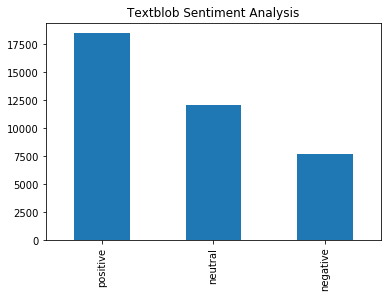

In [10]:
df.tb_sentiment.value_counts().plot(kind='bar',title="Textblob Sentiment Analysis")

Overall, sentiment is mostly positive, which is consistent with the preview above. I'll need to factor in that Textblob is not necessarily 100% accurate, and many times interpretation can be subjective, especially when the tweet itself is negative but the overall opinion toward vaccines is conveyed as positive. 

To look deeper into positive vs negative, I'm going to show the most frequent words and visualize with a word cloud. I'll start by separating positive, negative, and neutral data into separate dataframes.

In [11]:
negatives = df[df['tb_sentiment'] == 'negative']
positives = df[df['tb_sentiment'] == 'positive']
neutral = df[df['tb_sentiment'] == 'neutral']

Then I am using NLTK's stopwords list and adding punctuation as well as the term vaccine as this shoudl be in every tweet. I can see that Twint is also pulling in some things as weird characters so I'm removing those as well.

In [61]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``', 'â€�', 'ðÿ™']
stopwords_list += punct_list
stopwords_list.extend(['vaccine', 'vaccines'])

When I first ran the text analysis I saw that contractions were being split and strings like "n't" were showing up as frequent words. To solve this I am using a py file and function imported from [this repository](https://github.com/dipanjanS/practical-machine-learning-with-python) in order to map contractions to full words. 

In [36]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


Then I'm going to incorporate this into a tokenize function that will map contractions, lowercase words, and remove stopwords and symbols all at once.

In [37]:
def tokenize(tweet):
    tweet = expand_contractions(tweet)
    tokens = nltk.word_tokenize(tweet)
    words_lower = [word.lower() for word in tokens]
    words_stopped = [word for word in words_lower if word not in stopwords_list]
    return words_stopped

In [39]:
processed_data_positive = list(map(tokenize, positives['clean_text']))
processed_data_negative = list(map(tokenize, negatives['clean_text']))

processed_data_positive[0]

['definitely',
 'required',
 'every',
 'public',
 'location',
 'library',
 'dmv',
 'etc',
 'also',
 'private',
 'locations',
 'grocery',
 'stores',
 'etc',
 'countries',
 'suffering',
 'lol',
 'us',
 'japan',
 'still',
 'state',
 'emergency',
 'canada',
 'barely',
 'virus',
 'stopped']

To visualize word clouds, I'm compiling a frequency distribution of most common words in positive and negative labeled data.

In [41]:
pos_tweet_concat = []
for tweet in processed_data_positive:
    pos_tweet_concat += tweet
    
pos_tweet_freqdist = FreqDist(pos_tweet_concat)
# pos_tweet_freqdist.most_common(2000)

[('get', 4320),
 ('covid', 2952),
 ('people', 2564),
 ('first', 2395),
 ('got', 2229),
 ('amp', 2220),
 ('getting', 1576),
 ('new', 1511),
 ('dose', 1503),
 ('like', 1407),
 ('one', 1322),
 ('vaccinated', 1238),
 ('today', 1236),
 ('us', 1213),
 ('’', 1191),
 ('covid-19', 1170),
 ('would', 1168),
 ('shot', 1158),
 ('ðÿ', 1089),
 ('good', 1082),
 ('covid19', 959),
 ('know', 939),
 ('need', 903),
 ('many', 892),
 ('still', 886),
 ('take', 843),
 ('right', 771),
 ('time', 769),
 ('pfizer', 763),
 ('day', 746),
 ('available', 742),
 ('second', 734),
 ('make', 723),
 ('also', 719),
 ('even', 717),
 ('really', 707),
 ('moderna', 698),
 ('go', 697),
 ('appointment', 670),
 ('see', 663),
 ('going', 660),
 ('”', 644),
 ('better', 643),
 ('everyone', 642),
 ('much', 630),
 ('work', 625),
 ('think', 621),
 ('back', 621),
 ('great', 620),
 ('want', 608),
 ('2', 599),
 ('year', 597),
 ('safe', 570),
 ('free', 563),
 ('j', 558),
 ('health', 550),
 ('nyc', 541),
 ('‘', 530),
 ('able', 525),
 ('effect

In [42]:
neg_tweet_concat = []
for tweet in processed_data_negative:
    neg_tweet_concat += tweet
    
neg_tweet_freqdist = FreqDist(neg_tweet_concat)
# neg_tweet_freqdist.most_common(2000)

[('get', 1741),
 ('people', 1281),
 ('covid', 1207),
 ('got', 854),
 ('like', 787),
 ('amp', 758),
 ('getting', 709),
 ('one', 546),
 ('would', 537),
 ('us', 480),
 ('take', 457),
 ('vaccinated', 434),
 ('still', 428),
 ('know', 368),
 ('go', 365),
 ('even', 350),
 ('going', 349),
 ('dose', 346),
 ('bad', 346),
 ('want', 336),
 ('shot', 335),
 ('need', 331),
 ('second', 331),
 ('shit', 326),
 ('covid-19', 318),
 ('think', 300),
 ('time', 299),
 ('today', 296),
 ('also', 281),
 ('day', 278),
 ('sick', 274),
 ('’', 270),
 ('long', 260),
 ('ðÿ', 259),
 ('new', 257),
 ('work', 254),
 ('make', 250),
 ('trump', 248),
 ('really', 245),
 ('first', 245),
 ('covid19', 244),
 ('fucking', 242),
 ('virus', 237),
 ('could', 233),
 ('year', 230),
 ('least', 229),
 ('2', 229),
 ('appointment', 222),
 ('rollout', 220),
 ('black', 219),
 ('feel', 218),
 ('side', 215),
 ('pfizer', 214),
 ('fuck', 210),
 ('health', 207),
 ('”', 205),
 ('mean', 205),
 ('way', 205),
 ('said', 205),
 ('hard', 201),
 ('back',

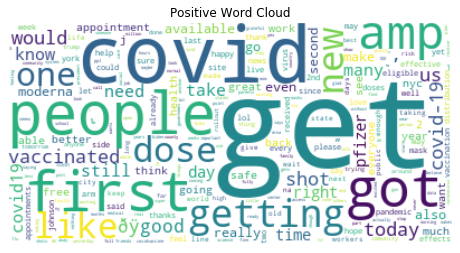

In [43]:
p_wc = WordCloud(background_color="white", max_words=2000)
p_wc.generate_from_frequencies(pos_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(p_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Positive Word Cloud')
plt.show()


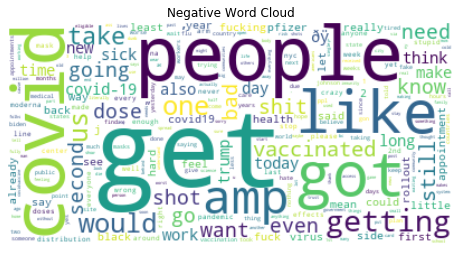

In [44]:
n_wc = WordCloud(background_color="white", max_words=2000)
n_wc.generate_from_frequencies(neg_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(n_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Negative Word Cloud')
plt.show()

WC Analysis


Next, I want to create a dataframe that shows how sentiment trends over time, which I'll use to correlate with the vaccination rate data. I'll do this by taking the average polarity score over time overall, and then for each city.

In [45]:
sent_over_time = df[['date', 'tb_polarity']].sort_values(by ='date')
sent_over_time['date'] =pd.to_datetime(sent_over_time['date'])
sent_over_time = sent_over_time.groupby('date').mean()

Text(0.5, 1.0, 'Polarity Score Over Time')

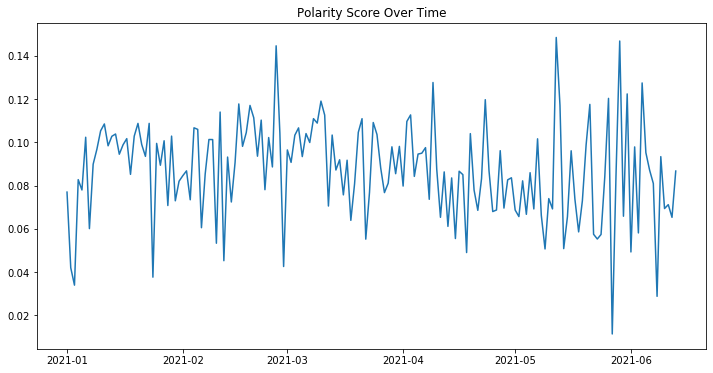

In [46]:
fig = plt.figure(figsize=(12, 6))
plt.plot(sent_over_time)
plt.title("Polarity Score Over Time")

Overall, the trend looks pretty random with a few dramatic spikes. Let's take a closer look at different locations. 

In [47]:
def sent_by_location(df, location):
    location_df = df[df['geo'] == location]
    return location_df[['date', 'tb_polarity']].sort_values(by ='date').groupby('date').mean()

In [48]:
hou_sent = sent_by_location(df, 'houston')
chi_sent = sent_by_location(df, 'chicago')
nyc_sent = sent_by_location(df, 'nyc')
la_sent = sent_by_location(df, 'la')

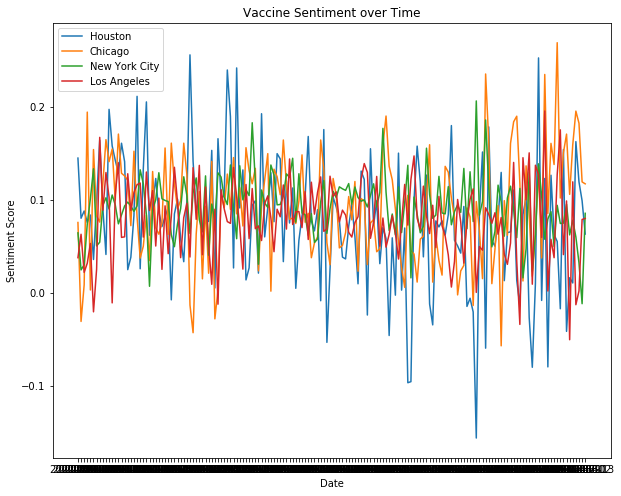

In [49]:
fig = plt.figure(figsize=(10, 8))
plt.plot(hou_sent, label='Houston')  
plt.plot(chi_sent, label='Chicago')  
plt.plot(nyc_sent, label='New York City')
plt.plot(la_sent, label='Los Angeles')
plt.xlabel('Date')  
plt.ylabel('Sentiment Score') 
plt.title("Vaccine Sentiment over Time")  
plt.legend() 

In [50]:
#exporting these dataframes to use in my other notebook

# hou_sent.to_csv('data/houston_sentiment.csv')
# chi_sent.to_csv('data/chicago_sentiment.csv')
# nyc_sent.to_csv('data/nyc_sentiment.csv')
# la_sent.to_csv('data/la_sentiment.csv')

## Cluster Analysis

https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

In [52]:
# Create Dictionary
id2word = corpora.Dictionary(processed_data_positive)
# Create Corpus
texts = processed_data_positive
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]


In [55]:

# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"get" + 0.015*"first" + 0.013*"got" + 0.012*"like" + 0.009*"covid" + '
  '0.008*"dose" + 0.006*"getting" + 0.006*"would" + 0.006*"shot" + '
  '0.005*"covid-19"'),
 (1,
  '0.017*"covid" + 0.015*"amp" + 0.011*"get" + 0.010*"people" + 0.006*"dose" + '
  '0.006*"got" + 0.005*"covid-19" + 0.005*"ðÿ" + 0.005*"”" + 0.005*"new"'),
 (2,
  '0.017*"people" + 0.014*"get" + 0.008*"first" + 0.007*"new" + 0.006*"us" + '
  '0.006*"covid19" + 0.006*"would" + 0.005*"covid" + 0.005*"still" + '
  '0.005*"amp"'),
 (3,
  '0.019*"get" + 0.010*"’" + 0.008*"ðÿ" + 0.007*"got" + 0.006*"people" + '
  '0.006*"first" + 0.006*"getting" + 0.005*"‰" + 0.005*"really" + 0.005*"one"'),
 (4,
  '0.015*"covid" + 0.009*"first" + 0.008*"get" + 0.007*"got" + '
  '0.007*"vaccinated" + 0.007*"getting" + 0.006*"amp" + 0.006*"one" + '
  '0.005*"people" + 0.005*"day"')]


In [58]:
# Visualize the topics
pyLDAvis.enable_notebook()

In [59]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [60]:
with open('LDAvis_prepared.pickle', 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open('LDAvis_prepared.pickle', 'rb') as f:
    LDAvis_prepared = pickle.load(f)

    # pyLDAvis.save_html(LDAvis_prepared)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.022232  0.047145  1       1        24.612788
1     -0.009067  0.009856  2       1        24.445777
0     -0.015320 -0.070310  3       1        19.413032
4     -0.034089  0.008831  4       1        17.103592
3      0.080708  0.004477  5       1        14.424811, topic_info=         Term         Freq        Total Category  logprob  loglift
149   ’        1104.000000  1104.000000  Default  30.0000  30.0000
77    get      4120.000000  4120.000000  Default  29.0000  29.0000
152   covid    2963.000000  2963.000000  Default  28.0000  28.0000
52    like     1430.000000  1430.000000  Default  27.0000  27.0000
147   ðÿ       1000.000000  1000.000000  Default  26.0000  26.0000
...   ..               ...          ...      ...      ...      ...
52    like     145.873194   1430.509576  Topic5  -5.6396  -0.3468 
152   covid    183.113952   2963.981935  Topic5  -5.4122  -0.8480 
1460  could    98.987656    514.855125   Topic5  -6.0273   0.2873 
105   covid19  112.709476   957.312135   Topic5  -5.8975  -0.2031 
370   dose     107.097981   1323.627574  Topic5  -5.9486  -0.5782 

[441 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
352   1      0.424518  1   
352   2      0.178744  1   
352   3      0.168814  1   
352   4      0.136541  1   
352   5      0.091855  1   
...  ..           ... ..   
425   3      0.136429  �   
425   4      0.048151  �   
425   5      0.056176  �   
7136  1      0.045412  �ðÿ�
7136  2      0.908247  �ðÿ�

[1076 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 4])